In [1]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd '/content/gdrive/My Drive/Real_Time_assignment_6'

[Errno 2] No such file or directory: '/content/gdrive/My Drive/Real_Time_assignment_6'
/content


In [3]:
!pip install d2l==1.0.0a0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.2/121.2 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.0 MB/s eta 0:00:00


In [4]:
!pip install matplotlib
%matplotlib inline
!pip install matplotlib-inline
import sys
!{sys.executable} -m pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import collections
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch.optim as optim


In [6]:
class PositionWiseFFN(nn.Module):  
    def __init__(self, ffn_num_hiddens, ffn_num_outputs, num_layers=5):
        super().__init__()
        layers = []
        for i in range(num_layers):
            layers.append(nn.LazyLinear(ffn_num_hiddens))
            layers.append(nn.ReLU())
        layers.append(nn.LazyLinear(ffn_num_outputs))
        self.net = nn.Sequential(*layers)

    def forward(self, X):
        return self.net(X)

In [7]:
class AddNorm(nn.Module): 
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [8]:
class TransformerEncoderBlock(nn.Module):  
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False):
        super().__init__()
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads, dropout, use_bias)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [9]:
class TransformerEncoder(d2l.Encoder): 
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, use_bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerEncoderBlock(num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))

    def forward(self, X, valid_lens):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

In [10]:
class TransformerDecoderBlock(nn.Module):
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = d2l.MultiHeadAttention(num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            dec_valid_lens = torch.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [11]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerDecoderBlock(num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

In [12]:
data = d2l.MTFraEng(batch_size=128)
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4
encoder = TransformerEncoder(len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout)
decoder = TransformerDecoder(len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.0015)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [13]:
model

Seq2Seq(
  (encoder): TransformerEncoder(
    (embedding): Embedding(194, 256)
    (pos_encoding): PositionalEncoding(
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (blks): Sequential(
      (block0): TransformerEncoderBlock(
        (attention): MultiHeadAttention(
          (attention): DotProductAttention(
            (dropout): Dropout(p=0.2, inplace=False)
          )
          (W_q): LazyLinear(in_features=0, out_features=256, bias=False)
          (W_k): LazyLinear(in_features=0, out_features=256, bias=False)
          (W_v): LazyLinear(in_features=0, out_features=256, bias=False)
          (W_o): LazyLinear(in_features=0, out_features=256, bias=False)
        )
        (addnorm1): AddNorm(
          (dropout): Dropout(p=0.2, inplace=False)
          (ln): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        )
        (ffn): PositionWiseFFN(
          (net): Sequential(
            (0): LazyLinear(in_features=0, out_features=64, bias=True)
            (1): Re

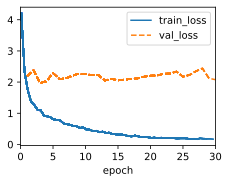

In [14]:
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [15]:
pip install torchinfo


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
from torchinfo import summary
batch_size = 128
summary(model)

Layer (type:depth-idx)                                  Param #
Seq2Seq                                                 --
├─TransformerEncoder: 1-1                               --
│    └─Embedding: 2-1                                   49,664
│    └─PositionalEncoding: 2-2                          --
│    │    └─Dropout: 3-1                                --
│    └─Sequential: 2-3                                  --
│    │    └─TransformerEncoderBlock: 3-2                312,896
│    │    └─TransformerEncoderBlock: 3-3                312,896
├─TransformerDecoder: 1-2                               --
│    └─Embedding: 2-4                                   54,784
│    └─PositionalEncoding: 2-5                          --
│    │    └─Dropout: 3-4                                --
│    └─Sequential: 2-6                                  --
│    │    └─TransformerDecoderBlock: 3-5                575,552
│    │    └─TransformerDecoderBlock: 3-6                575,552
│    └─Linear: 2-7     

In [17]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['<unk>', '!'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


In [18]:
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True)
enc_attention_weights = torch.cat(model.encoder.attention_weights, 0)
shape = (num_blks, num_heads, -1, data.num_steps)
enc_attention_weights = enc_attention_weights.reshape(shape)
d2l.check_shape(enc_attention_weights,
                (num_blks, num_heads, data.num_steps, data.num_steps))

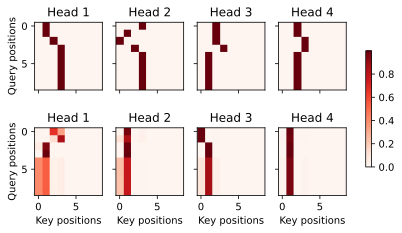

In [19]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

In [20]:
import pandas as pd

dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weights
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
shape = (-1, 2, num_blks, num_heads, data.num_steps)
dec_attention_weights = dec_attention_weights_filled.reshape(shape)
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)

d2l.check_shape(dec_self_attention_weights,
                (num_blks, num_heads, data.num_steps, data.num_steps))
d2l.check_shape(dec_inter_attention_weights,
                (num_blks, num_heads, data.num_steps, data.num_steps))

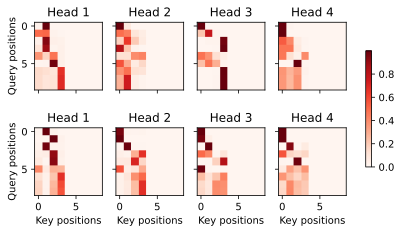

In [21]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))